In [470]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import plotly_express as px
import plotly.io as pio
import plotly.graph_objs as go
import pickle

 
import sys
sys.path.append('/Users/tracy/masters/capstone/ethereum')

# from dashboard.dashboard import (
#     surge_index,
#     surge_chart
# )
from web_rebuild.dashboard import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# get stuff
import pandas as pd
import numpy as np
import pickle

# load model
with open('../rf_test_model.pkl', 'rb') as model:
    rf = pickle.load(model)

# load data
df = pd.read_csv("../blocks.csv")
df2 = pd.read_csv("../transactions.csv")
#df_history = st.cache(pd.read_csv)("history.csv")

#################
# data pipeline #
#################

df2_agg = df2[['block_timestamp', 'receipt_effective_gas_price', 'max_priority_fee_per_gas']].groupby('block_timestamp').agg(['mean', 'count'])
df2_agg.columns = df2_agg.columns.map('_'.join).str.strip('_')
df_merge = df.merge(right=df2_agg, how='inner', on='block_timestamp')
df_merge = pd.DataFrame(df_merge).sort_values(by='block_timestamp', ascending=True)
df_merge = df_merge[-200:] # need 200 to do 100-ago division on last of 100 most recent

cols = ['base_fee_per_gas', 'receipt_effective_gas_price_count', 'receipt_effective_gas_price_mean', 'max_priority_fee_per_gas_mean']
for col in cols:
    # Last 5 blocks
    df_merge[col+'_pct_chg_last_5'] = df_merge[col]/df_merge[col].shift(5)-1
    # 100 blocks ago to 5 blocks ago percentage changes
    df_merge[col+'_pct_chg_last_100_to_5'] = df_merge[col].shift(5)/df_merge[col].shift(100)-1

df_merge = df_merge[-100:] # only want those 100 most recent which have complete percents

# datetime dummy variables
df_merge['local_date'] = pd.to_datetime(df_merge['block_timestamp']).dt.tz_localize('utc').dt.tz_convert('US/Eastern')
df_merge['date'] = df_merge['local_date'].dt.date
df_merge['hour'] = df_merge['local_date'].dt.hour
df_merge['minute'] = df_merge['local_date'].dt.minute
df_merge['weekday'] = df_merge['local_date'].dt.weekday

df_merge['hour_dummy'] = 0
start_hour = 2
end_hour = 9
mask = (df_merge['hour'] < start_hour) | (df_merge['hour'] > end_hour)
df_merge.loc[mask, 'hour_dummy'] = 1

df_merge['minute_dummy'] = 0
start_minute = 1
end_minute = 6
mask = (df_merge['minute'] >= start_minute) & (df_merge['minute'] <= end_minute)
df_merge.loc[mask, 'minute_dummy'] = 1

df_merge['weekday_dummy'] = 0
start_weekday = 1
end_weekday = 4
mask = (df_merge['weekday'] >= start_weekday) & (df_merge['weekday'] <= end_weekday)
df_merge.loc[mask, 'weekday_dummy'] = 1

#rename key columns to match the model's expectations
df_merge.rename(columns={
       'receipt_effective_gas_price_count_pct_chg_last_5':'number_transactions_in_block_pct_chg_last_5',
       'receipt_effective_gas_price_count_pct_chg_last_100_to_5':'number_transactions_in_block_pct_chg_last_100_to_5',
       'receipt_effective_gas_price_mean_pct_chg_last_5':'effective_gas_price_mean_pct_chg_last_5',
       'receipt_effective_gas_price_mean_pct_chg_last_100_to_5':'effective_gas_price_mean_pct_chg_last_100_to_5',
        }, inplace=True)

# get only columns needed
features = ['base_fee_per_gas_pct_chg_last_100_to_5', 
            'base_fee_per_gas_pct_chg_last_5',
            'number_transactions_in_block_pct_chg_last_100_to_5', 
            'number_transactions_in_block_pct_chg_last_5',
            'effective_gas_price_mean_pct_chg_last_100_to_5', 
            'effective_gas_price_mean_pct_chg_last_5',
            'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5', 
            'max_priority_fee_per_gas_mean_pct_chg_last_5',
            'minute_dummy', 'hour_dummy', 'weekday_dummy'
            ]
df_predict = df_merge[features]

# winsorize: clip at 95th percentile value
mask100 = (df_predict['max_priority_fee_per_gas_mean_pct_chg_last_100_to_5'] >= 17.677177)
df_predict.loc[mask100, 'max_priority_fee_per_gas_mean_pct_chg_last_100_to_5'] = 17.677177
mask5 = (df_predict['max_priority_fee_per_gas_mean_pct_chg_last_5'] >= 10.24462)
df_predict.loc[mask5, 'max_priority_fee_per_gas_mean_pct_chg_last_5'] = 10.24462

###############
# predictions #
###############

predicted = rf.predict(df_predict)


chart = df_merge[['block_timestamp','receipt_effective_gas_price_mean']]
chart['predicted'] = predicted
chart.set_index('block_timestamp')
chart.to_csv('../chart.csv', index=False)

/Users/tracy/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/tracy/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/tracy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [184]:
#predicted

In [14]:
files.keys()

dict_keys(['blocks', 'transactions', 'predicted'])

In [513]:
tz = "US/Eastern"

files = {
    "blocks" : '../blocks.csv',
    "transactions" : '../transactions.csv',
    "predicted" : '../chart.csv'
}

data = {k : pd.read_csv(v, index_col=False) for k, v in files.items()}

In [502]:
for k, v in data.items():
    v['block_timestamp'] = pd.to_datetime(v['block_timestamp'])
    v['block_timestamp'] = v['block_timestamp'].dt.tz_localize("UTC").dt.tz_convert(tz)
    
    if k != "transactions":
        v.set_index(v['block_timestamp'], inplace=True)
        v.drop(columns='block_timestamp', inplace=True)

In [508]:
#data

In [484]:
#clean_predicted(data['predicted'])

In [500]:
#data['blocks']

In [510]:
#clean_dates(data, tz=tz)

In [526]:
clean_predicted(data["predicted"])

,receipt_effective_gas_price_mean,predicted
block_timestamp,,
2021-11-30 10:49:43-05:00,1.197941e+11,NaN
2021-11-30 10:49:44-05:00,1.197941e+11,NaN
2021-11-30 10:49:45-05:00,1.197941e+11,NaN
2021-11-30 10:49:46-05:00,1.197941e+11,NaN
2021-11-30 10:49:47-05:00,1.197941e+11,NaN
...,...,...
2021-11-30 11:13:23-05:00,NaN,9.207839e+10
2021-11-30 11:13:24-05:00,NaN,9.207839e+10
2021-11-30 11:13:25-05:00,NaN,9.207839e+10


In [531]:
surge_index(data["predicted"])["receipt_effective_gas_price_mean"][-1]

1.2538088605348485

In [528]:
clean_predicted(data["predicted"])

,receipt_effective_gas_price_mean,predicted
block_timestamp,,
2021-11-30 10:49:43-05:00,1.197941e+11,NaN
2021-11-30 10:49:44-05:00,1.197941e+11,NaN
2021-11-30 10:49:45-05:00,1.197941e+11,NaN
2021-11-30 10:49:46-05:00,1.197941e+11,NaN
2021-11-30 10:49:47-05:00,1.197941e+11,NaN
...,...,...
2021-11-30 11:13:23-05:00,NaN,9.207839e+10
2021-11-30 11:13:24-05:00,NaN,9.207839e+10
2021-11-30 11:13:25-05:00,NaN,9.207839e+10


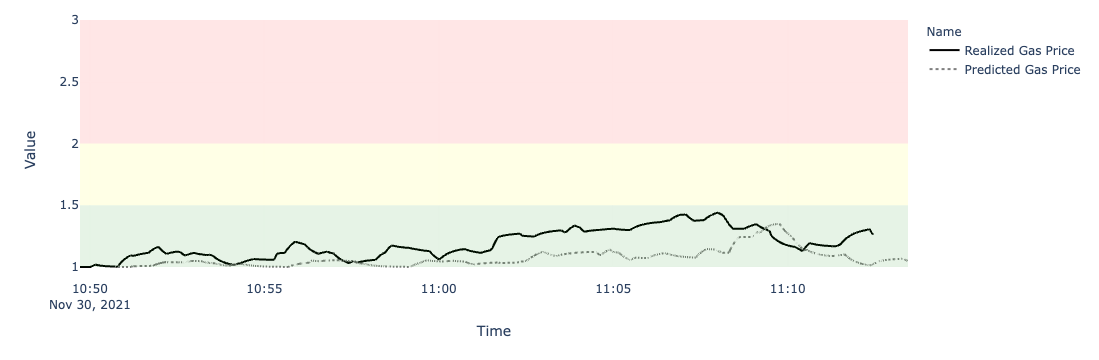

In [527]:
surge_chart(clean_predicted(data["predicted"]))

In [514]:
data = clean_dates(data, tz=tz)

blocks
transactions
predicted


In [524]:
surge_index(data['predicted'])['predicted'][-1]

1.1233222832224492

In [519]:
thresh_df = surge_index(clean_predicted(data["predicted"]))
thresh_df["predicted"][-1]

1.052379215987069

In [515]:
clean_predicted(data['predicted'])

,receipt_effective_gas_price_mean,predicted
block_timestamp,,
2021-11-30 10:49:43-05:00,1.197941e+11,NaN
2021-11-30 10:49:44-05:00,1.197941e+11,NaN
2021-11-30 10:49:45-05:00,1.197941e+11,NaN
2021-11-30 10:49:46-05:00,1.197941e+11,NaN
2021-11-30 10:49:47-05:00,1.197941e+11,NaN
...,...,...
2021-11-30 11:13:23-05:00,NaN,9.207839e+10
2021-11-30 11:13:24-05:00,NaN,9.207839e+10
2021-11-30 11:13:25-05:00,NaN,9.207839e+10


In [189]:
# preds = data["predicted"]['predicted']
# preds.index = preds.index + pd.offsets.Minute()

In [467]:
preds_df = data["predicted"].copy().sort_index().resample('s').ffill()
preds_df = pd.concat([
    preds_df["receipt_effective_gas_price_mean"],
    pd.Series(
        preds_df['predicted'].values, 
        index=preds_df['predicted'].index + pd.offsets.Minute(),
        name="predicted"
    )
], axis=1)

chart_df = surge_index(preds_df)
chart_df.columns = [['Realized Gas Price', 'Predicted Gas Price']]

In [468]:
data["predicted"]

,receipt_effective_gas_price_mean,predicted
block_timestamp,,
2021-11-30 10:49:43-05:00,1.197941e+11,9.119814e+10
2021-11-30 10:50:01-05:00,1.218046e+11,9.119814e+10
2021-11-30 10:50:03-05:00,1.247563e+11,9.119814e+10
2021-11-30 10:50:11-05:00,1.187208e+11,9.327116e+10
2021-11-30 10:50:16-05:00,1.169524e+11,9.211373e+10
...,...,...
2021-11-30 11:11:32-05:00,1.818917e+11,9.969569e+10
2021-11-30 11:12:13-05:00,1.835150e+11,9.998643e+10
2021-11-30 11:12:18-05:00,1.853467e+11,9.644677e+10


In [19]:
df = chart_df.unstack().reset_index()
df.columns = ['Name', 'Time', 'Value']

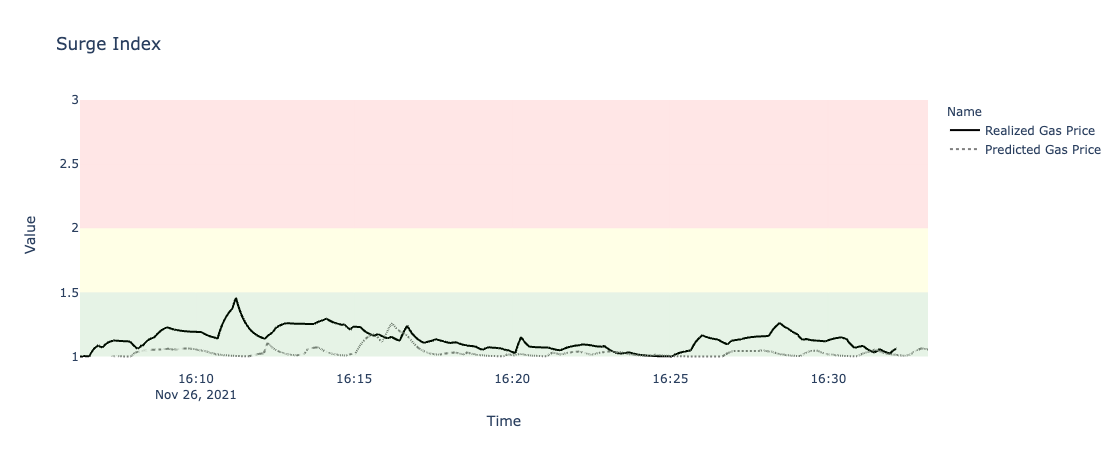

In [282]:
surge_chart(preds_df)

In [ ]:
# ### idea for the 
# - Show vs recent highest and lowest

In [306]:
import plotly.figure_factory as ff

In [434]:
data["predicted"]

,receipt_effective_gas_price_mean,predicted
block_timestamp,,
2021-11-30 10:49:43-05:00,1.197941e+11,9.119814e+10
2021-11-30 10:50:01-05:00,1.218046e+11,9.119814e+10
2021-11-30 10:50:03-05:00,1.247563e+11,9.119814e+10
2021-11-30 10:50:11-05:00,1.187208e+11,9.327116e+10
2021-11-30 10:50:16-05:00,1.169524e+11,9.211373e+10
...,...,...
2021-11-30 11:11:32-05:00,1.818917e+11,9.969569e+10
2021-11-30 11:12:13-05:00,1.835150e+11,9.998643e+10
2021-11-30 11:12:18-05:00,1.853467e+11,9.644677e+10


In [437]:
chart_df = surge_index(data["predicted"])
chart_df = data["predicted"]
chart_df.columns = [['Realized Gas Price', 'Predicted Gas Price']]
df = chart_df.unstack().reset_index()
df.columns = ['Name', 'Time', 'Value']

In [459]:
chart_df[-1:][('Realized Gas Price', )][0]

155555106860.44138

In [422]:
import sys
sys.path.append('/Users/tracy/masters/capstone/ethereum/web_rebuild')

In [438]:
from web_rebuild.dashboard import gas_hist

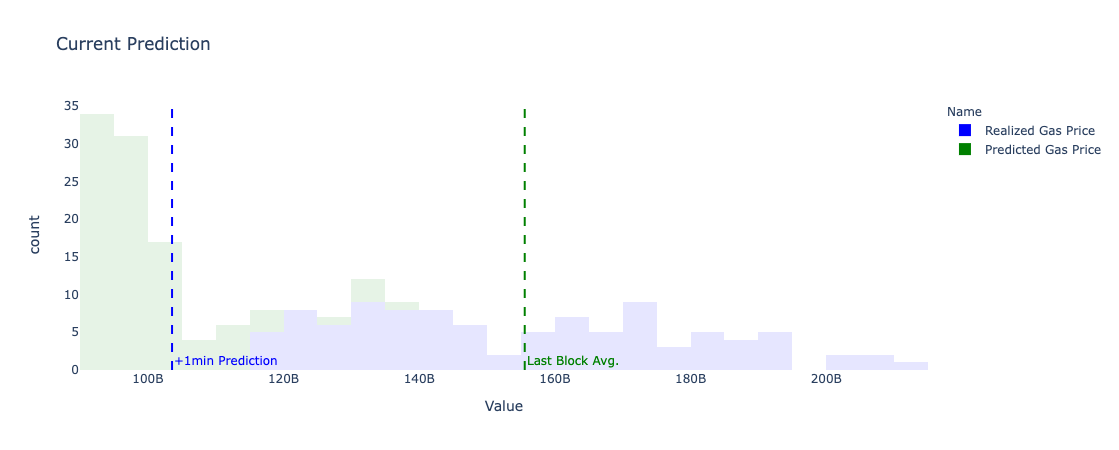

In [532]:
gas_hist(data["predicted"])

In [436]:
chart_df[-1:]['Predicted Gas Price'][0]

,receipt_effective_gas_price_mean,predicted
block_timestamp,,
2021-11-30 10:49:43-05:00,1.197941e+11,9.119814e+10
2021-11-30 10:50:01-05:00,1.218046e+11,9.119814e+10
2021-11-30 10:50:03-05:00,1.247563e+11,9.119814e+10
2021-11-30 10:50:11-05:00,1.187208e+11,9.327116e+10
2021-11-30 10:50:16-05:00,1.169524e+11,9.211373e+10
...,...,...
2021-11-30 11:11:32-05:00,1.818917e+11,9.969569e+10
2021-11-30 11:12:13-05:00,1.835150e+11,9.998643e+10
2021-11-30 11:12:18-05:00,1.853467e+11,9.644677e+10


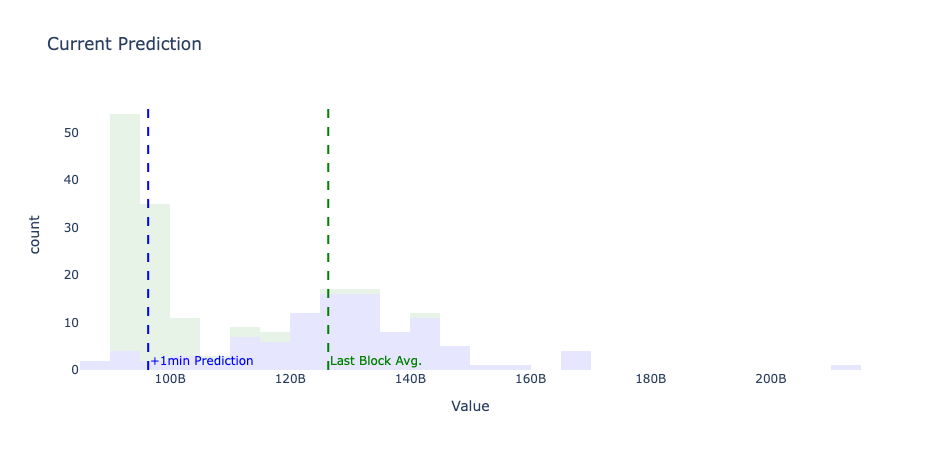

In [418]:
fig = px.histogram(
    df, 
    x="Value", 
    color="Name", 
    opacity=0.1,
    nbins=30,
    color_discrete_map={
        'Predicted Gas Price' : 'green',
        'Realized Gas Price' : 'blue'
    },
    #marginal="violin",
    title="Current Prediction"
)
fig.add_vline(
    x=chart_df[-1:]['Realized Gas Price'][0], 
    line_dash='dash',
    line_color='green',
    annotation_text="Last Block Avg.",
    annotation_position="bottom right",
    annotation_font_color="green"
)
fig.add_vline(
    x=chart_df[-1:]['Predicted Gas Price'][0], 
    line_dash='dash', 
    line_color='blue',
    annotation_text="+1min Prediction",
    annotation_position="bottom right",
    annotation_font_color="blue"
)
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    #'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.update_layout(showlegend=False)
fig.show()

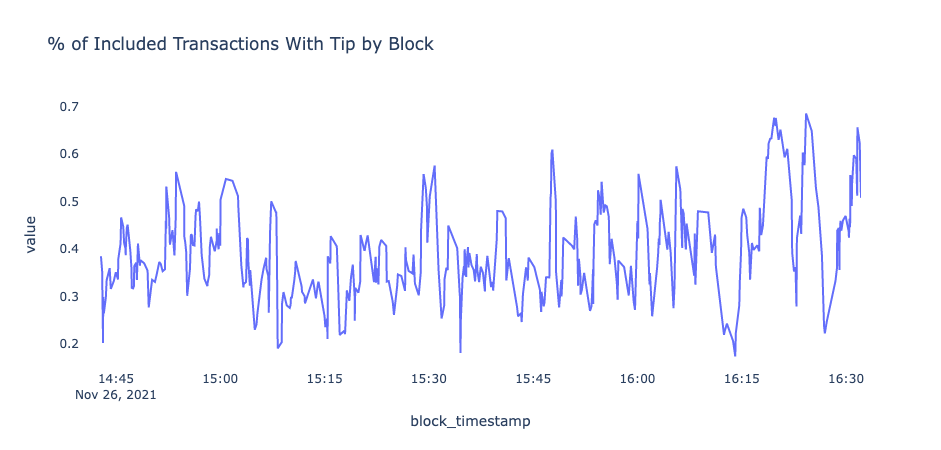

In [414]:
has_tip = tx.groupby([
    tx["max_priority_fee_per_gas"] == 0, 
    tx["block_timestamp"]
]).count()["max_priority_fee_per_gas"].unstack(0)
has_tip_pct = has_tip[True] / (has_tip.sum(1))
fig = px.line(has_tip_pct.rolling(5).mean(), title='% of Included Transactions With Tip by Block')
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.update_layout(showlegend=False)

In [406]:
data["blocks"]

,base_fee_per_gas
block_timestamp,
2021-11-26 16:32:09-05:00,116925004757
2021-11-26 16:31:58-05:00,121935382610
2021-11-26 16:31:38-05:00,108389042873
2021-11-26 16:31:36-05:00,123043231276
2021-11-26 16:31:28-05:00,118132043184
...,...
2021-11-26 15:32:48-05:00,101632253377
2021-11-26 15:32:43-05:00,111328001027
2021-11-26 15:32:32-05:00,109482183896


In [ ]:
### show complexity of recent transactions
# show receipt status of transactions

In [182]:
block_cutoff = tx["block_timestamp"].sort_values().unique()[-5:].min()
recent_tx = tx[tx["block_timestamp"] >= block_cutoff].copy()

In [187]:
#px.scatter(recent_tx["max_priority_fee_per_gas"], recent_tx["receipt_effective_gas_price"])

In [287]:
bins_max = recent_tx["max_priority_fee_per_gas"].max()
bins_min = 0
n_bins = 10

bins = {i : (bins_max - bins_min) / (n_bins - i) if i > 0 else -1 for i in range(n_bins)}
recent_tx["bin"] = pd.cut(
    recent_tx["max_priority_fee_per_gas"], list(bins.values()), labels=[i for i in range(n_bins - 1)]
)
recent_tx["bin"]

0       0
1       0
2       0
3       0
4       0
       ..
1295    0
1296    0
1297    0
1298    0
1299    0
Name: bin, Length: 1300, dtype: category
Categories (9, int64): [0 < 1 < 2 < 3 ... 5 < 6 < 7 < 8]

In [288]:
recent_tx.groupby('bin').count()

,block_timestamp,max_priority_fee_per_gas,receipt_effective_gas_price
bin,,,
0,1286,1286,1286
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,0,0,0
8,14,14,14


In [188]:
n_bins = 5
bins = [
    recent_tx["max_priority_fee_per_gas"].quantile(i / n_bins) for i in range(1, n_bins)
]
bins

[0.0, 0.0, 0.0, 1653188801.8000007]

In [171]:
recent_tx["bin"] = pd.cut(
    recent_tx["receipt_effective_gas_price"], [0, 112404042873, ]#, labels=[str(i) for i in range(3)]
)

recent_tx.groupby(by=["bin"]).count()

,block_timestamp,max_priority_fee_per_gas,receipt_effective_gas_price
bin,,,
"(0, 112404042873]",650,650,650


In [152]:
recent_tx.groupby(by=["block_timestamp", "bin"]).count()["receipt_effective_gas_price"].unstack("bin")

bin,0,1,2,3,4,5,6,7,8,9
block_timestamp,,,,,,,,,,
2021-11-26 16:31:28-05:00,169.0,34.0,39.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-26 16:31:36-05:00,5.0,3.0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-26 16:31:38-05:00,713.0,46.0,40.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0
2021-11-26 16:31:58-05:00,68.0,36.0,22.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-26 16:32:09-05:00,91.0,14.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


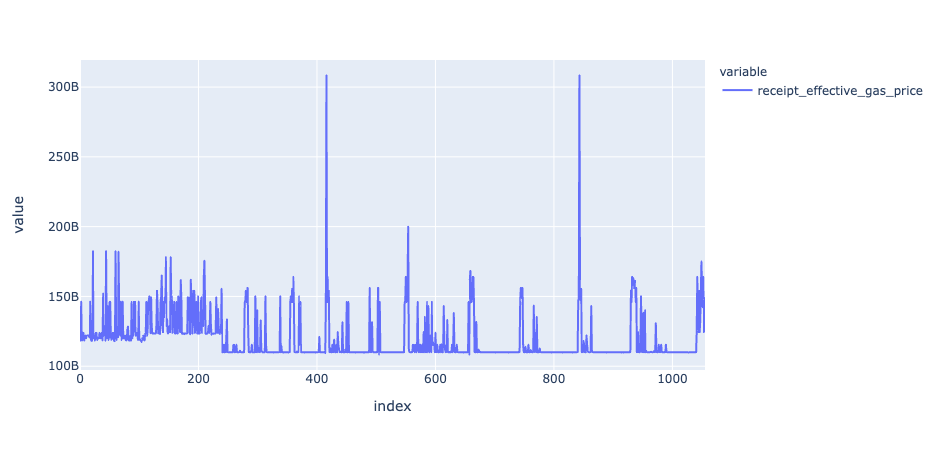

In [93]:
df = recent_tx["receipt_effective_gas_price"]
px.line(df)

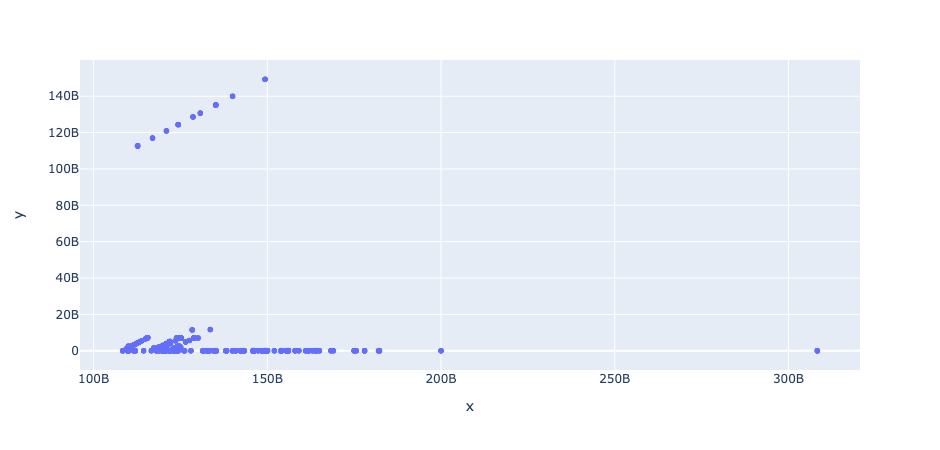

In [291]:
px.scatter(x=recent_tx["receipt_effective_gas_price"], y=recent_tx["max_priority_fee_per_gas"])

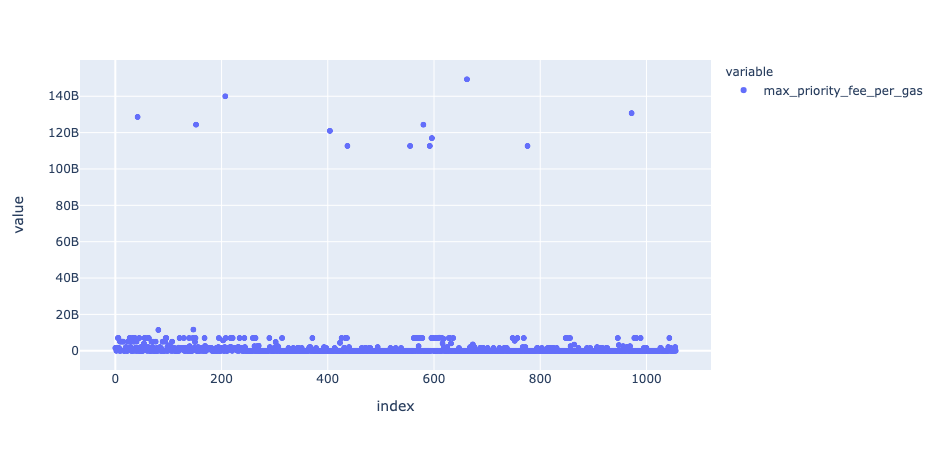

In [83]:
px.scatter(recent_tx["max_priority_fee_per_gas"])

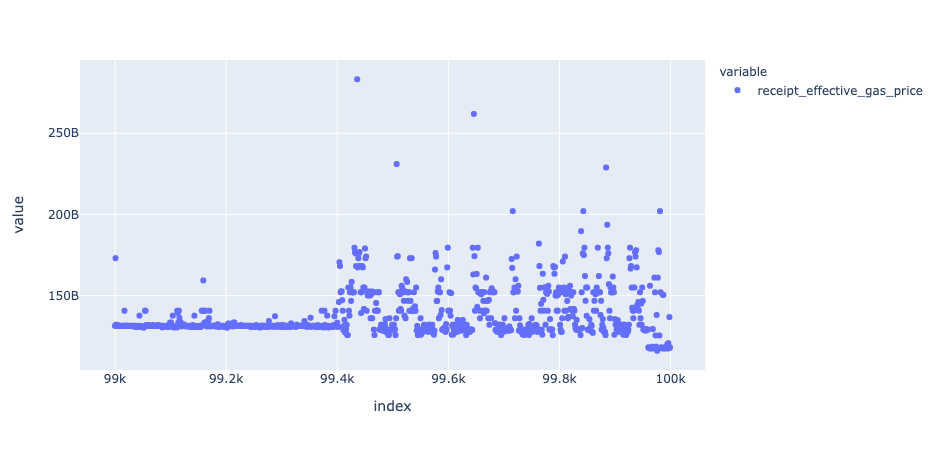

In [32]:
px.scatter(data["transactions"]["receipt_effective_gas_price"].tail(1000))